In [1]:
import scipy.io as sio, os
import pandas as pd
import gin
from stmetric.data.loaders import SOLTripletRatioDataset
import torch

sim = "/homes/cv300/Documents/timbre-metric/notebooks/lostanlen2020jasmp/experiments/similarity/ticelJudgments.mat"

mat = sio.loadmat(sim)
labels = mat['ensemble']

In [2]:
mat['ci'].shape

(31, 78)

In [3]:
labels = mat['ci'][0]
labels

array([ 6,  6,  1,  4,  4, 12, 12, 11, 14,  1,  1, 11, 11, 14, 14, 14, 14,
       11,  8, 11, 14, 14, 14, 11,  1, 11, 11, 11,  6, 11,  6,  6,  6, 11,
       11, 11, 13,  1, 11,  6,  6,  6,  5, 11, 11, 11,  6,  8,  1,  6,  6,
       11,  8, 13,  1,  3,  2,  3,  3,  3, 10,  6, 13,  7,  6,  6, 10,  1,
       11,  9, 12,  7,  5, 14, 11, 11, 11, 11], dtype=uint8)

In [3]:
gin.enter_interactive_mode()
gin.parse_config_file('/homes/cv300/Documents/timbre-metric/gin/doce/sol_template.gin')
ds = SOLTripletRatioDataset(test_instr=None, k=None, extend=True, feature='jtfs')

loading SOL seed and extended files
loading SOL features ...
loading triplets


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.62it/s]


In [4]:
import torch.nn.functional as F
import numpy as np

# compute pairwise euclidean distance matrix on features
# pdists = F.pairwise_distance(ds.features, ds.features[:, None, :])
pdists = torch.cdist(ds.features, ds.features)

def precision_at_k(pdists, idx, labels, k=5):
    # get top k queries
    sorted_idxs = pdists[idx].argsort()
    top_k = sorted_idxs[sorted_idxs != i][:k]
    # convert all items to their seed idx
    top_k = np.array([ds.ext_to_seed[int(i)] for i in top_k]) 
    top_k_labels = labels[top_k] 
    anchor_label = labels[ds.ext_to_seed[idx]]
    
    n_correct = (anchor_label == top_k_labels).sum()
    return n_correct

p_at_5 = 0
for n in range(mat['ci'].shape[0]):
    labels = mat['ci'][n]
    n_correct = 0
    n_total = 0
    for i in range(len(pdists)):
        n_correct += precision_at_k(pdists, i, labels)
        n_total += 5
    print(f"p@5 for subject {n}: {n_correct / n_total}")
    p_at_5 += n_correct / n_total
    
print(f"mean p@5: {p_at_5 / mat['ci'].shape[0]}")

p@5 for subject 0: 0.7706454707414006
p@5 for subject 1: 0.9259421680142524
p@5 for subject 2: 0.7975332328354118
p@5 for subject 3: 0.9145128134849938
p@5 for subject 4: 0.6559133890639989
p@5 for subject 5: 0.8192956009318898
p@5 for subject 6: 0.734795121282719
p@5 for subject 7: 0.6641359462792928
p@5 for subject 8: 0.8169932849116075
p@5 for subject 9: 0.7179114704673153
p@5 for subject 10: 0.7199397012470878
p@5 for subject 11: 0.8148280115115801
p@5 for subject 12: 0.8739756064135946
p@5 for subject 13: 0.7929286007948472
p@5 for subject 14: 0.6436891873372619
p@5 for subject 15: 0.8103604220912703
p@5 for subject 16: 0.7689187337261888
p@5 for subject 17: 0.6525147320816774
p@5 for subject 18: 0.8743319172262574
p@5 for subject 19: 0.8629847882691517
p@5 for subject 20: 0.8168288337673016
p@5 for subject 21: 0.780951075784569
p@5 for subject 22: 0.7869535425517336
p@5 for subject 23: 0.870659175003426


KeyboardInterrupt: 

In [11]:
labels = mat['ensemble'][0]
n_correct = 0
n_total = 0
for i in range(len(pdists)):
    n_correct += precision_at_k(pdists, i, labels)
    n_total += 5
print(f"p@5 for ensemble: {n_correct / n_total}")

p@5 for ensemble: 0.5861167002012072


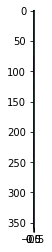

In [19]:
plt.imshow(ds.features[0, :, None], aspect='au')